### Determining actual neighbours in deskewed image using affine matrices

When deskewing, the actual neighbours are in the intermediated sheared image

We use trilinear interpolation by first determining neighbours in 3D, x0,y0,z0 to x8,y8,z8
from the sheared image. Once we find the neighbours, we apply an inverse shear transform to find the position of these neighbours in the raw data and interpolate these points

https://en.wikipedia.org/wiki/Trilinear_interpolation

In [1]:
import math
import pyclesperanto_prototype as cle
from pyclesperanto_prototype._tier8._affine_transform import _determine_translation_and_bounding_box
from skimage.io import imread
import numpy as np 
#Disable scientific notation for numbers
np.set_printoptions(suppress=True)

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

original_image = imread("D:\\OneDrive - wehi.edu.au\\WEHI_projects\\Lightsheet\\pyclesperanto_prototype\\data\\RBC_tiny.tif")
#"C:\\Users\\deepu\\OneDrive - wehi.edu.au\\WEHI_projects\\Lightsheet\\pyclesperanto_prototype\\data\\RBC_tiny.tif")
original_image = original_image[::4]
voxel_size_z_in_microns = voxel_size_z_in_microns * 4
print(original_image.shape)


#Defining Deskewing transform 

scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)
_,deskew_transform,translation = _determine_translation_and_bounding_box(original_image, deskew_transform)

deskew_transform._matrix
deskewed = cle.affine_transform(source= original_image,transform = deskew_transform,auto_size=True,linear_interpolation=True)
deskewed = cle.pull(deskewed)
print(deskewed.shape)

print("Current interpolation yields:")
cle.imshow(deskewed[:,200])

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\OneDrive - wehi.edu.au\\WEHI_projects\\Lightsheet\\pyclesperanto_prototype\\data\\RBC_tiny.tif'

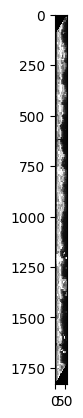

In [69]:
cle.imshow(cle.maximum_x_projection(deskewed))

Current interpolation yields:


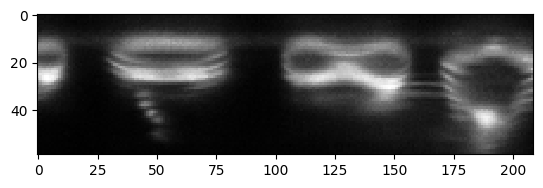

In [12]:
new_dz

0.5999999999999999

In [6]:
#Get shear transform
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor

#Inverse shear transform
shear_inverse = shear_transform.copy().inverse()


##rotation,scaling and translation
#second step of the deskewing workflow
rot_trans = cle.AffineTransform3D()
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
rot_trans.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
rot_trans.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)
rot_trans.translate(translation[0],translation[1],translation[2])

#inverse rotate translate matrix
rot_trans_inv = rot_trans.copy().inverse()

#inverse deskew
deskew_inverse = deskew_transform.copy().inverse()


In [24]:

#Bilinear interpolation

#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord_rev = rot_trans_inv._matrix@coord
print("On intermediate sheared image, reverse rot trans gives coordinates:", sheared_img_coord_rev)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, inverse shear gives coordinates:", sheared_img_coord)

#Get shear transform
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor


#Inverse shear transform
shear_inverse = shear_transform.copy().inverse()



#Find neighbours in the yz plane for the sheared image
transform_yz1_orth= cle.AffineTransform3D()
transform_yz2_orth= cle.AffineTransform3D()
transform_yz3_nearest= cle.AffineTransform3D()
transform_yz4_nearest= cle.AffineTransform3D()

#Distance between neighbours in xyz
z_step_orth = 1/voxel_size_z_in_microns
y_step_orth = voxel_size_y_in_microns

z_step_nearest = voxel_size_z_in_microns
y_step_nearest = voxel_size_y_in_microns


transform_yz1_orth.translate(translate_z=-z_step_orth)

transform_yz2_orth.translate(translate_z=z_step_orth)

transform_yz3_nearest.translate(translate_y=-y_step_nearest, translate_z=-z_step_nearest)

transform_yz4_nearest.translate(translate_y=y_step_nearest, translate_z=z_step_nearest)


yz1_orth_deskew = transform_yz1_orth._matrix@sheared_img_coord
yz2_orth_deskew  = transform_yz2_orth._matrix@sheared_img_coord




yz3_nearest_sheared = transform_yz3_nearest._matrix@sheared_img_coord
yz4_nearest_sheared = transform_yz4_nearest._matrix@sheared_img_coord

print("Neighbour in deskew (orthogonal neighbours)")
print("orth_before", yz1_orth_deskew)
print("orth after",yz2_orth_deskew)
print("nearest_before", yz3_nearest_sheared)
print("nearest after",yz4_nearest_sheared)

#get inverse shear transform
deskew_inverse = deskew_transform.copy().inverse()


yz1_orth = deskew_inverse._matrix@yz1_orth_deskew
yz2_orth = deskew_inverse._matrix@yz2_orth_deskew
yz3_nearest = shear_inverse._matrix@yz3_nearest_sheared
yz4_nearest = shear_inverse._matrix@yz4_nearest_sheared


print("Actual neighbours in the raw image")

print("orth_before ", yz1_orth)
print("orth after",yz2_orth)
print("Nearest before",yz3_nearest)
print("Nearest after",yz4_nearest)


Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On intermediate sheared image, reverse rot trans gives coordinates: [ 70.         420.83578736  48.11107853   1.        ]
On intermediate sheared image, inverse shear gives coordinates: [ 70.         420.83578736  48.11107853   1.        ]
Neighbour in deskew (orthogonal neighbours)
orth_before [ 70.         420.83578736  46.91107853   1.        ]
orth after [ 70.         420.83578736  49.31107853   1.        ]
nearest_before [ 70.         420.69079516  46.91107853   1.        ]
nearest after [ 70.         420.98077956  49.31107853   1.        ]
Actual neighbours in the raw image
orth_before  [70.         24.17784295 48.31830764  1.        ]
orth after [70.         19.37784295 48.82057536  1.        ]
Nearest before [70.         84.45599862 46.91107853  1.        ]
Nearest after [70.         67.54400138 49.31107853  1.        ]


In [28]:
plane_before = (464 - (21/np.tan(deskewing_angle_in_degrees * math.pi / 180.0)))/voxel_size_z_in_microns
plane_after= plane_before + 1
print(plane_before, plane_after)
l_before = (464 - (21/np.tan(deskewing_angle_in_degrees * math.pi / 180.0))) - (plane_before*voxel_size_z_in_microns)
l_after = voxel_size_z_in_microns - l_before
print(l_before, l_after)

356.3557775342113 357.3557775342113
0.0 1.2


In [32]:
z = 464
za = z/(np.sin(deskewing_angle_in_degrees * math.pi / 180.0))
virtual_pos_before = za + l_before*(np.sin(deskewing_angle_in_degrees * math.pi / 180.0))
virtual_pos_before
za

928.0000000000001

In [38]:
coord = [70,464,22,1]

rotate_tr = cle.AffineTransform3D()

rotate_tr.rotate(angle_in_degrees = deskewing_angle_in_degrees, axis=0)

rotate_tr._matrix@coord

array([ 70.        , 390.83578736, 251.05255888,   1.        ])

In [67]:
#Bilinear interpolation

#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord_rev = rot_trans_inv._matrix@coord
print("On intermediate sheared image, reverse rot trans gives coordinates:", sheared_img_coord_rev)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, inverse shear gives coordinates:", sheared_img_coord)

#Get shear transform
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor


#Inverse shear transform
shear_inverse = shear_transform.copy().inverse()



#Find neighbours in the yz plane for the sheared image
transform_yz1_orth= cle.AffineTransform3D()
transform_yz2_orth= cle.AffineTransform3D()
transform_yz3_nearest= cle.AffineTransform3D()
transform_yz4_nearest= cle.AffineTransform3D()

#Distance between neighbours in xyz
z_step_orth = 1/voxel_size_z_in_microns
y_step_orth = voxel_size_y_in_microns

z_step_nearest = 1
y_step_nearest = voxel_size_z_in_microns*np.tan(deskewing_angle_in_degrees * math.pi / 180.0)


transform_yz1_orth.translate(translate_z=z_step_orth)

transform_yz2_orth.translate(translate_z=-z_step_orth)

transform_yz3_nearest.translate(translate_y=y_step_nearest, translate_z=z_step_nearest)

transform_yz4_nearest.translate(translate_y=-y_step_nearest, translate_z=-z_step_nearest)


yz1_orth_deskew = transform_yz1_orth._matrix@coord
yz2_orth_deskew  = transform_yz2_orth._matrix@coord




yz3_nearest_deskew = transform_yz3_nearest._matrix@coord
yz4_nearest_deskew = transform_yz4_nearest._matrix@coord

print("Neighbour in deskew (orthogonal neighbours)")
print("orth_before", yz1_orth_deskew)
print("orth after",yz2_orth_deskew)
print("nearest_before", yz3_nearest_deskew)
print("nearest after",yz4_nearest_deskew)

#get inverse shear transform
deskew_inverse = deskew_transform.copy().inverse()


yz1_orth = deskew_inverse._matrix@yz1_orth_deskew
yz2_orth = deskew_inverse._matrix@yz2_orth_deskew
yz3_nearest = deskew_inverse._matrix@yz3_nearest_deskew
yz4_nearest = deskew_inverse._matrix@yz4_nearest_deskew


print("Actual neighbours in the raw image")

print("orth_before ", yz1_orth)
print("orth after",yz2_orth)
print("Nearest before",yz3_nearest)
print("Nearest after",yz4_nearest)

Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On intermediate sheared image, reverse rot trans gives coordinates: [ 70.         420.83578736  48.11107853   1.        ]
On intermediate sheared image, inverse shear gives coordinates: [ 70.         420.83578736  48.11107853   1.        ]
Neighbour in deskew (orthogonal neighbours)
orth_before [ 70.  464.   22.2   1. ]
orth after [ 70.  464.   19.8   1. ]
nearest_before [ 70.         464.69282032  22.2          1.        ]
nearest after [ 70.         463.30717968  19.8          1.        ]
Actual neighbours in the raw image
orth_before  [70.         73.6        48.36221238  1.        ]
orth after [70.         78.4        47.85994467  1.        ]
Nearest before [70.         73.6        48.44592367  1.        ]
Nearest after [70.         78.4        47.77623338  1.        ]


In [58]:
1/(voxel_size_z_in_microns/np.tan(deskewing_angle_in_degrees * math.pi / 180.0))

0.48112522432468807

In [61]:
(464 - voxel_size_z_in_microns/np.tan(deskewing_angle_in_degrees * math.pi / 180.0))/voxel_size_z_in_microns

384.9346158590978

Have to determine how the neighbours are defined!

Currently, using translations in y and z to get neighbours

### Trilinear interpolation?
Get neighbours in yz plane
* (y+1,z-1)
* (y-1,z-1)
* (y-1,z+1)
* (y+1,z+1)

Get neighbours in xy plane
* (x-1,y+1)
* (x-1,y-1)
* (x+1,y-1)
* (x+1,y+1)

In [7]:
#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)


#find neighbours using translation in xyz coordinates


transform_xyz1= cle.AffineTransform3D()
transform_xyz2= cle.AffineTransform3D()
transform_xyz3= cle.AffineTransform3D()
transform_xyz4= cle.AffineTransform3D()


transform_xyz5= cle.AffineTransform3D()
transform_xyz6= cle.AffineTransform3D()
transform_xyz7= cle.AffineTransform3D()
transform_xyz8= cle.AffineTransform3D()


#Distance between neighbours in xyz
z_step = voxel_size_z_in_microns
y_step = voxel_size_y_in_microns
x_step = voxel_size_x_in_microns


transform_xyz1.translate(translate_x=-x_step,translate_y=y_step,translate_z=-z_step)
transform_xyz2.translate(translate_x=-x_step,translate_y=-y_step,translate_z=-z_step)
transform_xyz3.translate(translate_x=x_step,translate_y=-y_step,translate_z=-z_step)
transform_xyz4.translate(translate_x=x_step,translate_y=y_step,translate_z=-z_step)

transform_xyz5.translate(translate_x=-x_step,translate_y=y_step,translate_z=z_step)
transform_xyz6.translate(translate_x=-x_step,translate_y=-y_step,translate_z=z_step)
transform_xyz7.translate(translate_x=x_step,translate_y=-y_step,translate_z=z_step)
transform_xyz8.translate(translate_x=x_step,translate_y=y_step,translate_z=z_step)


xyz1_deskewed = transform_xyz1._matrix@coord
xyz2_deskewed = transform_xyz2._matrix@coord

xyz3_deskewed = transform_xyz3._matrix@coord
xyz4_deskewed = transform_xyz4._matrix@coord


xyz5_deskewed = transform_xyz5._matrix@coord
xyz6_deskewed = transform_xyz6._matrix@coord

xyz7_deskewed = transform_xyz7._matrix@coord
xyz8_deskewed = transform_xyz8._matrix@coord


print("\Deskewed image neighbour coordinates plane 1")
print("bottom left", xyz1_deskewed)
print("top left",xyz2_deskewed)
print("top right",xyz3_deskewed)
print("bottom right",xyz4_deskewed)



print("Deskewed image neighbour coordinates plane 2")
print("bottom left", xyz5_deskewed)
print("top left",xyz6_deskewed)
print("top right",xyz7_deskewed)
print("bottom right",xyz8_deskewed)


#Apply inverse deskew transform to get the neighbouring coordinates in original image
xyz1 = deskew_inverse._matrix@xyz1_deskewed
xyz2 = deskew_inverse._matrix@xyz2_deskewed
xyz3 = deskew_inverse._matrix@xyz3_deskewed
xyz4 = deskew_inverse._matrix@xyz4_deskewed


xyz5 = deskew_inverse._matrix@xyz5_deskewed
xyz6 = deskew_inverse._matrix@xyz6_deskewed
xyz7 = deskew_inverse._matrix@xyz7_deskewed
xyz8 = deskew_inverse._matrix@xyz8_deskewed

print("\nActual neighbours in the raw image plane 1")

print("bottom left", xyz1)
print("top left",xyz2)
print("top right",xyz3)
print("bottom right",xyz4)

print("Actual neighbours in the raw image plane 2")

print("bottom left", xyz5)
print("top left",xyz6)
print("top right",xyz7)
print("bottom right",xyz8)




Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
\Deskewed image neighbour coordinates plane 1
bottom left [ 69.8550078 464.1449922  19.8         1.       ]
top left [ 69.8550078 463.8550078  19.8         1.       ]
top right [ 70.1449922 463.8550078  19.8         1.       ]
bottom right [ 70.1449922 464.1449922  19.8         1.       ]
Deskewed image neighbour coordinates plane 2
bottom left [ 69.8550078 464.1449922  22.2         1.       ]
top left [ 69.8550078 463.8550078  22.2         1.       ]
top right [ 70.1449922 463.8550078  22.2         1.       ]
bottom right [ 70.1449922 464.1449922  22.2         1.       ]

Actual neighbours in the raw image plane 1
bottom left [69.8550078  78.4        47.87746362  1.        ]
top left [69.8550078  78.4        47.84242572  1.        ]
top right [70.1449922  78.4        47.84242572  1.        ]
bottom right [70.1449922  78.4        47.87746362  1.        ]
Act

In [36]:
#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, coordinates are:", sheared_img_coord)


#get 8 coordinates



#Find neighbours in the yz plane for the sheared image
#Distance between neighbours in xyz
z_step = voxel_size_z_in_microns
y_step = voxel_size_y_in_microns
x_step = voxel_size_x_in_microns

transform_xyz1= cle.AffineTransform3D()
transform_xyz2= cle.AffineTransform3D()
transform_xyz3= cle.AffineTransform3D()
transform_xyz4= cle.AffineTransform3D()


transform_xyz5= cle.AffineTransform3D()
transform_xyz6= cle.AffineTransform3D()
transform_xyz7= cle.AffineTransform3D()
transform_xyz8= cle.AffineTransform3D()


transform_xyz1.translate(translate_x=-x_step,translate_y=y_step,translate_z=-z_step)
transform_xyz2.translate(translate_x=-x_step,translate_y=-y_step,translate_z=-z_step)
transform_xyz3.translate(translate_x=x_step,translate_y=-y_step,translate_z=-z_step)
transform_xyz4.translate(translate_x=x_step,translate_y=y_step,translate_z=-z_step)

transform_xyz5.translate(translate_x=-x_step,translate_y=y_step,translate_z=z_step)
transform_xyz6.translate(translate_x=-x_step,translate_y=-y_step,translate_z=z_step)
transform_xyz7.translate(translate_x=x_step,translate_y=-y_step,translate_z=z_step)
transform_xyz8.translate(translate_x=x_step,translate_y=y_step,translate_z=z_step)

orthogonal_plane2 = cle.AffineTransform3D()
transform_xyz8.translate(translate_x=x_step,translate_y=0,translate_z=z_step)


xyz1_sheared = transform_xyz1._matrix@sheared_img_coord
xyz2_sheared = transform_xyz2._matrix@sheared_img_coord

xyz3_sheared = transform_xyz3._matrix@sheared_img_coord
xyz4_sheared = transform_xyz4._matrix@sheared_img_coord


xyz5_sheared = transform_xyz5._matrix@sheared_img_coord
xyz6_sheared = transform_xyz6._matrix@sheared_img_coord

xyz7_sheared = transform_xyz7._matrix@sheared_img_coord
xyz8_sheared = transform_xyz8._matrix@sheared_img_coord


print("\nSheared image neighbour coordinates plane 1")
print("bottom left", xyz1_sheared)
print("top left",xyz2_sheared)
print("top right",xyz3_sheared)
print("bottom right",xyz4_sheared)



print("Sheared image neighbour coordinates plane 2")
print("bottom left", xyz5_sheared)
print("top left",xyz6_sheared)
print("top right",xyz7_sheared)
print("bottom right",xyz8_sheared)


#get inverse shear transform
shear_transform_inverse = shear_transform.copy().inverse()


xyz1 = shear_transform_inverse._matrix@xyz1_sheared
xyz2 = shear_transform_inverse._matrix@xyz2_sheared
xyz3 = shear_transform_inverse._matrix@xyz3_sheared
xyz4 = shear_transform_inverse._matrix@xyz4_sheared


xyz5 = shear_transform_inverse._matrix@xyz5_sheared
xyz6 = shear_transform_inverse._matrix@xyz6_sheared
xyz7 = shear_transform_inverse._matrix@xyz7_sheared
xyz8 = shear_transform_inverse._matrix@xyz8_sheared

print("\nActual neighbours in the raw image plane 1")

print("bottom left", xyz1)
print("top left",xyz2)
print("top right",xyz3)
print("bottom right",xyz4)

print("Actual neighbours in the raw image plane 2")

print("bottom left", xyz5)
print("top left",xyz6)
print("top right",xyz7)
print("bottom right",xyz8)



Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On intermediate sheared image, coordinates are: [ 70.         420.83578736  48.11107853   1.        ]

Sheared image neighbour coordinates plane 1
bottom left [ 69.8550078  420.98077956  46.91107853   1.        ]
top left [ 69.8550078  420.69079516  46.91107853   1.        ]
top right [ 70.1449922  420.69079516  46.91107853   1.        ]
bottom right [ 70.1449922  420.98077956  46.91107853   1.        ]
Sheared image neighbour coordinates plane 2
bottom left [ 69.8550078  420.98077956  49.31107853   1.        ]
top left [ 69.8550078  420.69079516  49.31107853   1.        ]
top right [ 70.1449922  420.69079516  49.31107853   1.        ]
bottom right [ 70.1449922  420.98077956  49.31107853   1.        ]

Actual neighbours in the raw image plane 1
bottom left [69.8550078  84.74598302 46.91107853  1.        ]
top left [69.8550078  84.45599862 46.91107853  1.    

In [42]:

import numpy as np
import math

def angle_between_three_points(pointA, pointB, pointC):
    
    x1x2s = math.pow((pointA[0] - pointB[0]),2)
    x1x3s = math.pow((pointA[0] - pointC[0]),2)
    x2x3s = math.pow((pointB[0] - pointC[0]),2)
    
    y1y2s = math.pow((pointA[1] - pointB[1]),2)
    y1y3s = math.pow((pointA[1] - pointC[1]),2)
    y2y3s = math.pow((pointB[1] - pointC[1]),2)

    cosine_angle = np.arccos((x1x2s + y1y2s + x2x3s + y2y3s - x1x3s - y1y3s)/(2*math.sqrt(x1x2s + y1y2s)*math.sqrt(x2x3s + y2y3s)))

    return np.degrees(cosine_angle)

print(angle_between_three_points(sheared_img_coord,xyz7_sheared,xyz8_sheared))

#origin

angle_between_three_points(xyz8_sheared,sheared_img_coord,xyz7_sheared)

45.0000000000028


89.99999999999439

In [27]:
voxel_size_z_in_microns

1.2

In [24]:
import math 
math.degrees(math.atan(420.54580296/421.12577176))

44.96051932817026

In [20]:
virtual_plane = 420.83578736 - (48.11107853 - math.tan(deskewing_angle_in_degrees * math.pi / 180.0))
virtual_plane

373.3020590991896

In [13]:
#Testint the affine matrix steps and if the coordinates match
#Creating affine matrix for the rotation and translation step
trans_rotate =cle.AffineTransform3D()
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
trans_rotate.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
trans_rotate.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)
trans_rotate.translate(translate_z=59)
print(trans_rotate._matrix)

trans_rotate_inverse = trans_rotate.copy().inverse()
trans_rotate_inverse._matrix

coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#inverse rotate
#Apply inverse deskew to find corresponding coordinaes in original image
rotate_inv_coord =  trans_rotate_inverse._matrix@coord
print("On sheared image, invert rotate coordinates are:", rotate_inv_coord)


#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, coordinates are:", sheared_img_coord)


Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On shearedimage, invert rotate coordinates are: [ 70.         420.83578736  48.11107853   1.        ]
On intermediate sheared image, coordinates are: [ 70.         420.83578736  48.11107853   1.        ]


In [19]:


#Bilinear interpolation

#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)



#Find neighbours in the yz plane for the sheared image
transform_yz1= cle.AffineTransform3D()
transform_yz2= cle.AffineTransform3D()
transform_yz3= cle.AffineTransform3D()
transform_yz4= cle.AffineTransform3D()

#Distance between neighbours in xyz
z_step = voxel_size_z_in_microns
y_step = voxel_size_y_in_microns




transform_yz1.translate(translate_y= -y_step,translate_z=-z_step)

#orth1
transform_yz2.translate(translate_y=-y_step)

transform_yz3.translate(translate_y=y_step,translate_z=z_step)

#orth2
transform_yz4.translate(translate_y=y_step)


yz1_skew = transform_yz1._matrix@coord
yz2_skew = transform_yz2._matrix@coord

yz3_skew = transform_yz3._matrix@coord
yz4_skew = transform_yz4._matrix@coord

print("Deskew image neighbour coordinates (actual neighbours)")
print("top left ", yz1_skew)
print("top right",yz2_skew)
print("bottom left",yz3_skew)
print("bottom right",yz4_skew)

#get inverse shear transform
deskew_inverse = deskew_transform.copy().inverse()


yz1 = deskew_inverse._matrix@yz1_skew
yz2 = deskew_inverse._matrix@yz2_skew
yz3 = deskew_inverse._matrix@yz3_skew
yz4 = deskew_inverse._matrix@yz4_skew


print("Actual neighbours in the raw image")

print("top left ", yz1)
print("top right",yz2)
print("bottom left",yz3)
print("bottom right",yz4)


Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
Deskew image neighbour coordinates (actual neighbours)
top left  [ 70.        463.8550078  19.8         1.       ]
top right [ 70.        463.8550078  21.          1.       ]
bottom left [ 70.        464.1449922  22.2         1.       ]
bottom right [ 70.        464.1449922  21.          1.       ]
Actual neighbours in the raw image
top left  [70.         78.4        47.84242572  1.        ]
top right [70.         76.         48.09355958  1.        ]
bottom left [70.         73.6        48.37973133  1.        ]
bottom right [70.         76.         48.12859747  1.        ]


In [46]:

#Bilinear interpolation

#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_transform.copy().inverse()._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, coordinates are:", sheared_img_coord)

#Get shear transform
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor


#Inverse shear transform
shear_inverse = shear_transform.copy().inverse()



#Find neighbours in the yz plane for the sheared image
transform_yz1_orth= cle.AffineTransform3D()
transform_yz2_orth= cle.AffineTransform3D()
transform_yz3_nearest= cle.AffineTransform3D()
transform_yz4_nearest= cle.AffineTransform3D()

#Distance between neighbours in xyz
z_step_orth = voxel_size_y_in_microns
y_step_orth = voxel_size_y_in_microns

z_step_nearest = voxel_size_z_in_microns
y_step_nearest = voxel_size_y_in_microns


transform_yz1_orth.translate(translate_z=-z_step_orth)

transform_yz2_orth.translate(translate_z=z_step_orth)

transform_yz3_nearest.translate(translate_z=-z_step_nearest)

transform_yz4_nearest.translate(translate_z=z_step_nearest)


yz1_orth_deskew = transform_yz1_orth._matrix@coord
yz2_orth_deskew  = transform_yz2_orth._matrix@coord




yz3_nearest_sheared = transform_yz3_nearest._matrix@sheared_img_coord
yz4_nearest_sheared = transform_yz4_nearest._matrix@sheared_img_coord

print("Neighbour in deskew (orthogonal neighbours)")
print("orth_before", yz1_orth_deskew)
print("orth after",yz2_orth_deskew)
print("nearest_before", yz3_nearest_sheared)
print("nearest after",yz4_nearest_sheared)

#get inverse shear transform
deskew_inverse = deskew_transform.copy().inverse()


yz1_orth = deskew_inverse._matrix@yz1_orth_deskew
yz2_orth = deskew_inverse._matrix@yz2_orth_deskew
yz3_nearest = shear_inverse._matrix@yz3_nearest_sheared
yz4_nearest = shear_inverse._matrix@yz4_nearest_sheared


print("Actual neighbours in the raw image")

print("orth_before ", yz1_orth)
print("orth after",yz2_orth)
print("Nearest before",yz3_nearest)
print("Nearest after",yz4_nearest)


Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On intermediate sheared image, coordinates are: [ 70.         420.83578736  48.11107853   1.        ]
Neighbour in deskew (orthogonal neighbours)
orth_before [ 70.        464.         20.8550078   1.       ]
orth after [ 70.        464.         21.1449922   1.       ]
nearest_before [ 70.         420.83578736  46.91107853   1.        ]
nearest after [ 70.         420.83578736  49.31107853   1.        ]
Actual neighbours in the raw image
orth_before  [70.         76.2899844  48.08073482  1.        ]
orth after [70.         75.7100156  48.14142223  1.        ]
Nearest before [70.         84.60099082 46.91107853  1.        ]
Nearest after [70.         67.39900918 49.31107853  1.        ]


In [ ]:
# get the deskew coordinates and find orthogonal coordinates
#get deskew coord, translate by z+1 and z-1
#deskew inverse to get orthogonal coord

# get the raw coord
#translate by z+1 and z-1 to get nearest neighbours in raw plane